# Fiber Network Mesh Generation
This notebook demonstrates how to generate a mesh using the code in `mesh_generation.py`.

## Microtissue Fiber Network Generation
Complete workflow with parameter exploration and visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '/projectnb/me700/students/quan/assignments/fiber_network_active_contraction/src/fiber_network')
from mesh_generation import (
    FiberNetworkParams, 
    generate_sample_tissue_params,
    generate_fib_net_for_tissue,
    generate_fib_net_xdmf_meshio
)

### 1. Configuration Setup
All available parameters with sample values:

In [2]:
np.random.seed(0)  # For reproducibility

# Generate sample tissue geometry
tissue_pts, posts_pos, posts_radius, wound_shape = generate_sample_tissue_params()

# Full parameter configuration
config = FiberNetworkParams(
    # Tissue geometry (using sample values)
    tissue_points=tissue_pts,
    dimension=2,
    
    # Fiber generation parameters
    num_fibers=250,
    fiber_length={
        "distribution": "normal",  # Options: constant/uniform/normal
        "min": 0.1, # for uniform distribution
        "max": 0.5, # for uniform distribution
        "mean": 0.3, # for normal distribution and constant
        "std_dev": 0.05 # for normal distribution and constant
    },
    fiber_orientation={
        "distribution": "random_orientation",  # Options: random_orientation/uniform/von_mises
        "range": [0, 180],  # For uniform distribution
        "mean_angle": 0,  # For von Mises
        "concentration": 0.0  # For von Mises (higher = more aligned)
    },
    fiber_radii={
        "distribution": "normal",  # Options: constant/uniform/normal
        "mean": 0.01,
        "std_dev": 0.002
    },
    
    # Micropost configuration
    post_positions=posts_pos,
    post_radius=posts_radius,
    post_tolerance=1e-6,
    
    # Wound parameters
    wound_shape=wound_shape,
    
    # Spatial distribution control
    num_patches_x=2,
    num_patches_y=2
)

### 2. Generate and Visualize Network
2D visualization colored by fiber index

In [3]:
# Generate the fiber network
fiber_network = generate_fib_net_for_tissue(config)

In [ ]:
# # Check for duplicate fibers
# unique_fibers = np.unique(fiber_network.fibers, axis=0)
# if len(unique_fibers) != len(fiber_network.fibers):
#     print("Warning: Duplicate fibers detected.")

# # Check for near-zero-length fibers
# fiber_lengths = np.sqrt((fiber_network.fibers[:, 2] - fiber_network.fibers[:, 0])**2 +
#                         (fiber_network.fibers[:, 3] - fiber_network.fibers[:, 1])**2)
# if np.any(fiber_lengths < 1e-6):
#     print("Warning: Near-zero-length fibers detected.")

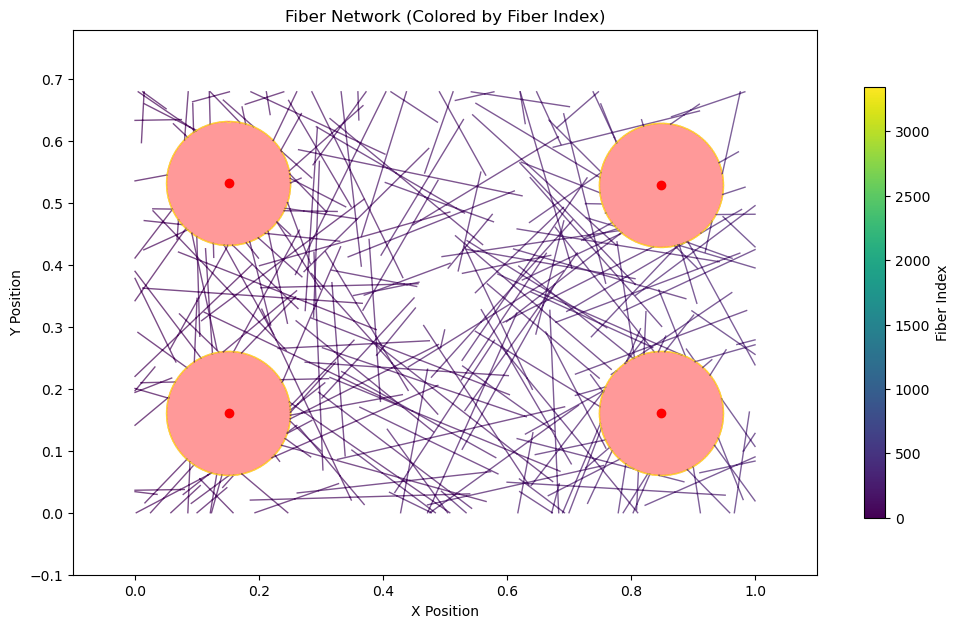

In [14]:
# Create colormap for fiber indices
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(fiber_network.indices))

# Plot configuration
plt.figure(figsize=(12, 8), dpi=100)

# Plot fibers with index-based coloring
for idx, fiber in enumerate(fiber_network.fibers):
    plt.plot([fiber[0], fiber[2]], [fiber[1], fiber[3]], 
             color=cmap(norm(fiber_network.indices[idx])), 
             lw=1.0, 
             alpha=0.7)

# Plot microposts
for post in posts_pos:
    plt.gca().add_patch(plt.Circle(post, posts_radius, color='red', alpha=0.4))

posts_pos_test = np.array([[0.100917431,0.110091743],[0.899082569,0.110091743],
                        [0.100917431,0.581039755],[0.899082569,0.577981651]])
post_shift = np.array([[1,1],[-1,1],[1,-1],[-1,-1]]) * 0.05
posts_pos_test+=post_shift
plt.scatter(posts_pos_test[:,0], posts_pos_test[:,1],
            color='red', alpha=1.0) # s=posts_radius*100

# Formatting
plt.xlim(tissue_pts[:,0].min()-0.1, tissue_pts[:,0].max()+0.1)
plt.ylim(tissue_pts[:,1].min()-0.1, tissue_pts[:,1].max()+0.1)
plt.gca().set_aspect('equal')
plt.title("Fiber Network (Colored by Fiber Index)")
plt.xlabel("X Position")
plt.ylabel("Y Position")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.7)
cbar.set_label('Fiber Index')

### 3. Export to XDMF Format
Mesh refinement with characteristic length

In [5]:
generate_fib_net_xdmf_meshio(
    fiber_network.fibers,
    f_name="microtissue_mesh",
    output_xdmf="./example_files/meshes/",
    fib_ind=fiber_network.indices,
    characteristic_length=0.006
)

print("XDMF export complete. Files saved in ./output/ directory")

Number of fibers before accounting for characteristic length: 3346
Number of fibers after accounting for characteristic length: 9506
Fiber network successfully written to ./example_files/meshes/microtissue_mesh.xdmf
XDMF export complete. Files saved in ./output/ directory
